In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import lightgbm as lgb



import warnings

# suppress runtime warnings that occur during printing
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feature/__results__.html
/kaggle/input/feature/All_patient_data_aggregated_full.csv
/kaggle/input/feature/__notebook__.ipynb
/kaggle/input/feature/__output__.json
/kaggle/input/feature/custom.css
/kaggle/input/feature/__results___files/__results___34_1.png
/kaggle/input/notebookdata/pcms_hackathon_data/test/patient.csv
/kaggle/input/notebookdata/pcms_hackathon_data/test/visit.csv
/kaggle/input/notebookdata/pcms_hackathon_data/test/care.csv
/kaggle/input/notebookdata/pcms_hackathon_data/test/diagnosis.csv
/kaggle/input/notebookdata/pcms_hackathon_data/train/patient.csv
/kaggle/input/notebookdata/pcms_hackathon_data/train/risk.csv
/kaggle/input/notebookdata/pcms_hackathon_data/train/visit.csv
/kaggle/input/notebookdata/pcms_hackathon_data/train/care.csv
/kaggle/input/notebookdata/pcms_hackathon_data/train/diagnosis.csv


In [3]:

# # load the csv files into dataframes/kaggle/input/notebookdata/pcms_hackathon_data/train/patient.csv
patient_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/train/patient.csv')
risk_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/train/risk.csv')
care_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/train/care.csv')
diagnosis_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/train/diagnosis.csv')
visit_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/train/visit.csv')


In [ ]:

patient_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/test/patient.csv')
# risk_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/test/risk.csv')
care_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/test/care.csv')
diagnosis_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/test/diagnosis.csv')
visit_df = pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/test/visit.csv')

In [4]:
patient_df = pd.merge(patient_df, risk_df, on='patient_id', how='left')

In [5]:
merged_df=patient_df

In [6]:
merged_df.head()

,patient_id,age,hot_spotter_identified_at,hot_spotter_readmission_flag,hot_spotter_chronic_flag,risk_score
0,291,56,2025-03-01,f,f,0.51
1,306,42,0001-01-01,f,f,0.61
2,310,71,2025-03-01,f,f,11.70
3,315,49,0001-01-01,f,f,0.65
4,318,25,0001-01-01,f,f,1.08


In [7]:
flag_cols = ['readmsn_ind']

for col in flag_cols:
    if col in visit_df.columns and visit_df[col].dtype == 'object':
        # Clean the string data first
        cleaned_series = visit_df[col].str.strip().str.lower()
        
        # Create a mapping dictionary
        mapping = {'f': True, 't': False}
        
        # Apply the map and convert to the nullable boolean type
        visit_df[col] = cleaned_series.map(mapping).astype('boolean')

print("Data types after robust conversion:")
print(visit_df[flag_cols].dtypes)

Data types after robust conversion:
readmsn_ind    boolean
dtype: object


In [8]:

# Define rule-based binning patterns (priority order, most specific first)
rules = [
    ('Respiratory Infection', r'infection|pneumonia|bronchitis|pharyngitis|laryngitis|tracheitis|tonsillitis|sinusitis|nasopharyngitis|flu|influenza|covid'),
    ('Lower Respiratory', r'pneumonia|bronchitis|bronchiolitis|wheezing|asthma|copd'),
    ('Upper Respiratory', r'cough|cold|throat|upper respiratory|pharyngitis|laryngitis'),
    ('ENT', r'otitis|ear|sinus|sinusitis|epistaxis|rhinitis|cerumen|tonsil|throat|pharynx|larynx'),
    ('Musculoskeletal', r'strain|sprain|fracture|contusion|myalgia|arthritis|back pain|shoulder|wrist|knee|hip|ligament|muscle|joint|tendon|osteo|sciatica'),
    ('Injury/Wound', r'injury|wound|laceration|open wound|foreign body|bite|burn|abrasion|crush|trauma|contusion|dislocation|fracture|amputation'),
    ('Skin/Soft Tissue', r'cellulitis|abscess|furuncle|erythematous|dermatitis|rash|swelling|urticaria|cyst|ulcer|bite|laceration|wound|pruritus'),
    ('GU', r'cystitis|urinary|bladder|hematuria|pyelonephritis|prostatitis|incontinence|urethritis'),
    ('GI', r'abdominal|gastro|nausea|vomiting|epigastric|colitis|diarrhea|constipation|appendicitis|gastritis|pancreatitis|hepatitis|hernia|peritonitis|cholecystitis|gallbladder|bleeding|hemorrhoids|gerd|reflux|diverticulitis'),
    ('Neurology/Psych', r'headache|migraine|dizz|giddiness|vertigo|syncope|collapse|seizure|epilepsy|paralysis|stroke|tremor|neuro|disorder|depression|anxiety|mood|insomnia|sleep'),
    ('Cardiovascular', r'chest pain|palpitations|hypertension|tachy|arrhythmia|heart failure|infarction|angina|embolism|thrombosis|atherosclerosis|hypotension|stemi|nstemi'),
    ('Obstetric/Gyne', r'pregnancy|labor|childbirth|preterm|vaginitis|menstruation|miscarriage|abortion|perineal|postpartum|uterovaginal|ovarian|endometriosis|fetal|maternal care|gestational'),
    ('Endocrine/Metabolic', r'diabetes|thyroid|metabolic|nutritional|obesity|hypoglycemia|ketoacidosis|electrolyte|hypokalemia|hyperglycemia'),
    ('Eye', r'conjunctivitis|hordeolum|chalazion|stye|blepharitis|cataract|glaucoma|corneal|iridocyclitis|retinal'),
    ('Other Infection', r'viral|bacterial|abscess|sepsis|tuberculosis|mononucleosis|infection'),
    ('Allergy/Immune', r'allergy|urticaria|anaphylaxis|angioedema|immune|contact dermatitis'),
    ('Pain', r'pain'),
    ('Other', r'fever|malaise|fatigue|unspecified|other|abnormal|screening|observation|follow-up'),
]

def bin_diagnosis(text):
    if pd.isnull(text):
        return 'Other'
    text = text.lower()
    for cat, pat in rules:
        if re.search(pat, text):
            return cat
    return 'Other'

# Apply binning function to diagnoses
visit_df['diag_bin'] = visit_df['prncpl_diag_nm'].apply(bin_diagnosis)

# One-hot encode the diag_bin column for ML input
diag_dummies = pd.get_dummies(visit_df['diag_bin'], prefix='diag', dtype=int)

def encode_is_chronic(value):
    if pd.isna(value):
        return -1
    elif value == True:
        return 1
    else:
        return 0

visit_df['readmsn_ind'] = visit_df['readmsn_ind'].apply(encode_is_chronic)

# New: Visit date parsing for advanced features
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'], errors='coerce')
visit_df['visit_end_dt'] = pd.to_datetime(visit_df['visit_end_dt'], errors='coerce')

# New: Visit duration
visit_df['visit_duration'] = (visit_df['visit_end_dt'] - visit_df['visit_start_dt']).dt.days

# New: Time since last visit and days between visits
visit_df = visit_df.sort_values(by=['patient_id', 'visit_start_dt'])
visit_df['days_since_last_visit'] = visit_df.groupby('patient_id')['visit_start_dt'].diff().dt.days

# New: Early readmission flag (within 7 days)
visit_df['early_readmit_flag'] = (
    (visit_df['days_since_last_visit'] <= 7) & (visit_df['days_since_last_visit'] >= 0)
).astype(int)

# New: Urgent care in last 30 days
latest_dates = visit_df.groupby('patient_id')['visit_start_dt'].max().rename('latest_visit')
visit_df = visit_df.merge(latest_dates, on='patient_id', how='left')
visit_df['urgent_care_recent_flag'] = (
    (visit_df['visit_type'] == 'URGENT CARE') &
    ((visit_df['latest_visit'] - visit_df['visit_start_dt']).dt.days <= 30)
).astype(int)

# 1. One-hot encode the 'visit_type' column
visit_type_dummies = pd.get_dummies(visit_df['visit_type'], prefix='visit_type', dtype=int)

# 2. Combine necessary columns for aggregation
df_for_agg = pd.concat([
    visit_df[['patient_id', 'readmsn_ind', 'visit_duration', 'days_since_last_visit',
              'early_readmit_flag', 'urgent_care_recent_flag']],
    visit_type_dummies, diag_dummies
], axis=1)

# 3. Aggregations
aggregations = {
    **{col_name: (col_name, 'sum') for col_name in visit_type_dummies.columns},
    **{col_name: (col_name, 'sum') for col_name in diag_dummies.columns},
    'visit_count': ('readmsn_ind', 'count'),
    'total_readmissions': ('readmsn_ind', 'sum'),
    
    # New aggregations:
    'avg_time_between_visits': ('days_since_last_visit', 'mean'),
    'max_time_since_first_visit': ('days_since_last_visit', 'max'),
    'avg_visit_duration': ('visit_duration', 'mean'),
    'early_readmit_flag_total': ('early_readmit_flag', 'sum'),
    'urgent_care_recent_flag_total': ('urgent_care_recent_flag', 'sum'),
}

# 4. Group by patient_id
patient_summary = df_for_agg.groupby('patient_id').agg(**aggregations).reset_index()

# 5. Force visit-type indicators into binary if needed
for col_name in visit_type_dummies.columns:
    patient_summary[col_name] = (patient_summary[col_name] > 0).astype(int)

# Display the final result
print(patient_summary)


      patient_id  visit_type_ER  visit_type_INPATIENT  visit_type_URGENT CARE  \
0             80              1                     0                       1   
1             98              0                     0                       1   
2            110              1                     0                       1   
3            125              0                     0                       1   
4            161              1                     0                       0   
...          ...            ...                   ...                     ...   
3082       82056              1                     0                       1   
3083       82060              1                     0                       1   
3084       82098              1                     0                       0   
3085       82117              0                     0                       1   
3086       82130              0                     0                       1   

      diag_Allergy/Immune  

In [9]:
merged_df = pd.merge(
    left=merged_df,
    right=patient_summary,
    how='left',
    on='patient_id'
)

# Display the final merged DataFrame
print("Patient DataFrame (patient_df):")
print(patient_df)
print("\nPatient Summary DataFrame (patient_summary):")
print(patient_summary)
print("\nFinal Merged DataFrame:")
# print(merged_df)
merged_df.columns

Patient DataFrame (patient_df):
      patient_id  age hot_spotter_identified_at hot_spotter_readmission_flag  \
0            291   56                2025-03-01                            f   
1            306   42                0001-01-01                            f   
2            310   71                2025-03-01                            f   
3            315   49                0001-01-01                            f   
4            318   25                0001-01-01                            f   
...          ...  ...                       ...                          ...   
7995       82117   45                0001-01-01                            f   
7996       82120   12                0001-01-01                            f   
7997       82130   49                0001-01-01                            f   
7998       82152   54                0001-01-01                            f   
7999           1   55                0001-01-01                            f   

     ho

Index(['patient_id', 'age', 'hot_spotter_identified_at',
       'hot_spotter_readmission_flag', 'hot_spotter_chronic_flag',
       'risk_score', 'visit_type_ER', 'visit_type_INPATIENT',
       'visit_type_URGENT CARE', 'diag_Allergy/Immune', 'diag_Cardiovascular',
       'diag_ENT', 'diag_Endocrine/Metabolic', 'diag_Eye', 'diag_GI',
       'diag_GU', 'diag_Injury/Wound', 'diag_Lower Respiratory',
       'diag_Musculoskeletal', 'diag_Neurology/Psych', 'diag_Obstetric/Gyne',
       'diag_Other', 'diag_Other Infection', 'diag_Pain',
       'diag_Respiratory Infection', 'diag_Skin/Soft Tissue',
       'diag_Upper Respiratory', 'visit_count', 'total_readmissions',
       'avg_time_between_visits', 'max_time_since_first_visit',
       'avg_visit_duration', 'early_readmit_flag_total',
       'urgent_care_recent_flag_total'],
      dtype='object')

In [10]:

# 1. classify 'condition_description' for each row first
def classify_description(description):
    if isinstance(description, str):
        lower_description = description.lower()
        if 'recent' in lower_description:
            return 'recent'
        if 'past' in lower_description:
            return 'past'
    return None # return None if no keyword is found or if it's not a string

diagnosis_df['condition_status'] = diagnosis_df['condition_description'].apply(classify_description)

# 2. create one-hot encoded columns for the condition names
diagnosis_dummies = pd.get_dummies(diagnosis_df['condition_name'])
diagnosis_with_dummies = pd.concat([diagnosis_df[['patient_id', 'condition_status']], diagnosis_dummies], axis=1)

# 3. create the 'all_conditions' code per patient
# group by patient, get the sum of dummies, and check if > 0 to create the code
conditions_agg = diagnosis_with_dummies.groupby('patient_id').sum(numeric_only=True)
conditions_agg['has_DIABETES'] = (conditions_agg['DIABETES'] > 0).astype(int)
conditions_agg['has_HYPERTENSION'] = (conditions_agg['HYPERTENSION'] > 0).astype(int)
conditions_agg['has_CANCER'] = (conditions_agg['CANCER'] > 0).astype(int)


# 4. aggregate the 'condition_status'
# we will create a single column that is 'recent' if any diagnosis for that patient is recent, else 'past'
def aggregate_status(series):
    if 'recent' in series.values:
        return 'recent'
    if 'past' in series.values:
        return 'past'
    return None # if neither, return None

status_agg = diagnosis_with_dummies.groupby('patient_id')['condition_status'].apply(aggregate_status).reset_index()
status_agg.rename(columns={'condition_status': 'condition_description'}, inplace=True)


# --- merge aggregated data back to the base dataframe ---
# merge the condition codes and flags
merged_df = pd.merge(merged_df, conditions_agg[['has_DIABETES', 'has_HYPERTENSION', 'has_CANCER']], on='patient_id', how='left')
# merge the aggregated status
merged_df = pd.merge(merged_df, status_agg, on='patient_id', how='left')


# fill NaN values for patients who had no diagnoses
merged_df['has_DIABETES'].fillna(0, inplace=True)
merged_df['has_HYPERTENSION'].fillna(0, inplace=True)
merged_df['has_CANCER'].fillna(0, inplace=True)

# the 'overall_condition_status' can remain NaN if a patient has no diagnoses

# convert boolean flags to integers for clarity
for col in ['has_DIABETES', 'has_HYPERTENSION', 'has_CANCER']:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].astype(int)


# --- final review and save ---
print("data aggregated with 'all_conditions' and 'condition_description' columns created.")
pd.set_option('display.max_columns', None)

print("\npreview of the final aggregated data:")
print(merged_df.head())

print(f"\nshape of the final dataframe: {merged_df.shape}")



print("\nunique values in 'overall_condition_status':")
print(merged_df['condition_description'].unique())


output_filename = '/kaggle/working/All_patient_data_aggregated_full.csv'
merged_df.to_csv(output_filename, index=False)
print(f"\nsuccessfully created the corrected aggregated file: '{output_filename}'")

# reset warning filters
warnings.resetwarnings()
# diagonsis_df.columns

data aggregated with 'all_conditions' and 'condition_description' columns created.

preview of the final aggregated data:
   patient_id  age hot_spotter_identified_at hot_spotter_readmission_flag  \
0         291   56                2025-03-01                            f   
1         306   42                0001-01-01                            f   
2         310   71                2025-03-01                            f   
3         315   49                0001-01-01                            f   
4         318   25                0001-01-01                            f   

  hot_spotter_chronic_flag  risk_score  visit_type_ER  visit_type_INPATIENT  \
0                        f        0.51            NaN                   NaN   
1                        f        0.61            NaN                   NaN   
2                        f       11.70            0.0                   1.0   
3                        f        0.65            NaN                   NaN   
4                   

/tmp/ipykernel_136/710665502.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['has_DIABETES'].fillna(0, inplace=True)
/tmp/ipykernel_136/710665502.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [11]:
flag_cols = ['hot_spotter_readmission_flag', 'hot_spotter_chronic_flag']

for col in flag_cols:
    if col in merged_df.columns and merged_df[col].dtype == 'object':
        # Clean the string data first
        cleaned_series = merged_df[col].str.strip().str.lower()
        
        # Create a mapping dictionary
        mapping = {'t': True, 'f': False}
        
        # Apply the map and convert to the nullable boolean type
        merged_df[col] = cleaned_series.map(mapping).astype('boolean')

print("Data types after robust conversion:")
print(merged_df[flag_cols].dtypes)

Data types after robust conversion:
hot_spotter_readmission_flag    boolean
hot_spotter_chronic_flag        boolean
dtype: object


In [12]:
merged_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,patient_id,age,hot_spotter_identified_at,hot_spotter_readmission_flag,hot_spotter_chronic_flag,risk_score,visit_type_ER,visit_type_INPATIENT,visit_type_URGENT CARE,diag_Allergy/Immune,diag_Cardiovascular,diag_ENT,diag_Endocrine/Metabolic,diag_Eye,diag_GI,diag_GU,diag_Injury/Wound,diag_Lower Respiratory,diag_Musculoskeletal,diag_Neurology/Psych,diag_Obstetric/Gyne,diag_Other,diag_Other Infection,diag_Pain,diag_Respiratory Infection,diag_Skin/Soft Tissue,diag_Upper Respiratory,visit_count,total_readmissions,avg_time_between_visits,max_time_since_first_visit,avg_visit_duration,early_readmit_flag_total,urgent_care_recent_flag_total,has_DIABETES,has_HYPERTENSION,has_CANCER,condition_description
0,291,56,2025-03-01,False,False,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,past
1,306,42,0001-01-01,False,False,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2,310,71,2025-03-01,False,False,11.70,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,2.000000,0.0,0.0,1,1,0,past
3,315,49,0001-01-01,False,False,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
4,318,25,0001-01-01,False,False,1.08,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,86.0,129.0,0.333333,0.0,0.0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,82117,45,0001-01-01,False,False,0.49,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.000000,0.0,1.0,0,0,0,NaN
7996,82120,12,0001-01-01,False,False,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
7997,82130,49,0001-01-01,False,False,0.62,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,0.000000,0.0,1.0,0,0,0,NaN
7998,82152,54,0001-01-01,False,False,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN


In [13]:
for col_name in visit_type_dummies.columns:
    merged_df[col_name].fillna(0,inplace=True)

for col_name in diag_dummies.columns:
    merged_df[col_name].fillna(0,inplace=True)

merged_df['visit_count'].fillna(0, inplace=True)

merged_df['total_readmissions'].fillna(0, inplace=True)

/tmp/ipykernel_136/1032996504.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df[col_name].fillna(0,inplace=True)
/tmp/ipykernel_136/1032996504.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [14]:

care_df=pd.read_csv('/kaggle/input/notebookdata/pcms_hackathon_data/train/care.csv')
care_df

# --- Convert date columns safely ---
date_columns = ['last_care_dt', 'next_care_dt']

for col in date_columns:
    if col in care_df.columns:
        care_df[col] = pd.to_datetime(care_df[col], errors='coerce')

# --- Calculate care gap days ---
if {'last_care_dt', 'next_care_dt'}.issubset(care_df.columns):
    care_df['care_gap_days'] = (
        (care_df['next_care_dt'] - care_df['last_care_dt']) / np.timedelta64(1, 'D')
    )
else:
    care_df['care_gap_days'] = np.nan

# Replace finite values with 1
care_df['care_gap_days'] = np.where(np.isfinite(care_df['care_gap_days']), 1, care_df['care_gap_days'])

# --- Handle missing cases ---
mask = care_df['last_care_dt'].isna() & care_df['next_care_dt'].notna()
care_df.loc[mask, 'care_gap_days'] = 2

mask = care_df['next_care_dt'].isna() & care_df['last_care_dt'].notna()
care_df.loc[mask, 'care_gap_days'] = 0

# --- Multi-label encode msrmnt_sub_type per patient ---
if {'patient_id', 'msrmnt_sub_type'}.issubset(care_df.columns):
    # Group care subtypes into lists per patient
    patient_care = care_df.groupby('patient_id')['msrmnt_sub_type'].apply(lambda x: list(set(x.dropna())))

    # Define all possible categories explicitly (to maintain consistency)
    all_care_types = [
        'DIASTOLIC BLOOD PRESSURE', 'HbA1c', 'SYSTOLIC BLOOD PRESSURE',
        'CHOLESTEROL', 'DIABETES', 'HYPERTENSION',
        'COLORECTAL CANCER', 'BREAST CANCER'
    ]

    mlb = MultiLabelBinarizer(classes=all_care_types)
    encoded = mlb.fit_transform(patient_care)

    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=patient_care.index)

    # Merge encoded results back into care_df (one row per patient)
    care_df = (
        care_df.drop_duplicates(subset=['patient_id'])
        .set_index('patient_id')
        .join(encoded_df, how='left')
        .reset_index()
    )
else:
    print("Columns 'patient_id' and/or 'msrmnt_sub_type' not found!")

# --- Convert care_gap_ind if it exists ---
care_gap_col = 'care_gap_ind'
if care_gap_col in care_df.columns:
    care_df[care_gap_col] = (
        care_df[care_gap_col]
        .fillna(0)
        .replace({'t': 1, 0: 0})
        .astype(int)
    )
else:
    print(f"Column {care_gap_col} not found in the data!")

# --- Drop unneeded columns ---
cols_to_drop = ['msrmnt_type', 'msrmnt_sub_type', 'msrmnt_value', 'last_care_dt', 'next_care_dt']
care_df = care_df.drop(columns=[c for c in cols_to_drop if c in care_df.columns])

# --- Summary ---
print("care_gap_days value counts:")
print(care_df['care_gap_days'].value_counts(dropna=False))

print("\nEncoded multi-label columns:")
print(list(encoded_df.columns))


care_gap_days value counts:
care_gap_days
0.0    230
1.0     53
2.0     37
Name: count, dtype: int64

Encoded multi-label columns:
['DIASTOLIC BLOOD PRESSURE', 'HbA1c', 'SYSTOLIC BLOOD PRESSURE', 'CHOLESTEROL', 'DIABETES', 'HYPERTENSION', 'COLORECTAL CANCER', 'BREAST CANCER']


/tmp/ipykernel_136/1401851514.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'t': 1, 0: 0})


In [17]:
patient_summary_df = care_df.groupby('patient_id').agg(
    # For 'care_gap_ind', find the maximum value
    care_gap_ind=('care_gap_ind', 'max'),
    
    # For 'msrmnt_sub_type_code', calculate the sum
    # msrmnt_sub_type_code_sum=('msrmnt_sub_type_code', 'sum')
).reset_index()

patient_summary_df[['care_gap_days',
       'DIASTOLIC BLOOD PRESSURE', 'HbA1c', 'SYSTOLIC BLOOD PRESSURE',
       'CHOLESTEROL', 'DIABETES', 'HYPERTENSION', 'COLORECTAL CANCER',
       'BREAST CANCER']] = care_df[['care_gap_days',
       'DIASTOLIC BLOOD PRESSURE', 'HbA1c', 'SYSTOLIC BLOOD PRESSURE',
       'CHOLESTEROL', 'DIABETES', 'HYPERTENSION', 'COLORECTAL CANCER',
       'BREAST CANCER']]

# Display the new DataFrame
print(patient_summary_df)

     patient_id  care_gap_ind  care_gap_days  DIASTOLIC BLOOD PRESSURE  HbA1c  \
0           186             1            0.0                         0      0   
1           197             1            0.0                         0      1   
2           449             1            2.0                         0      0   
3          1536             1            2.0                         0      0   
4          1552             1            0.0                         0      0   
..          ...           ...            ...                       ...    ...   
315       80876             1            0.0                         0      0   
316       81702             1            1.0                         0      0   
317       81798             1            0.0                         0      0   
318       81827             1            0.0                         0      0   
319       81948             1            0.0                         0      1   

     SYSTOLIC BLOOD PRESSUR

In [18]:

# --- Perform the left join ---
final_df = pd.merge(
    left=merged_df,
    right=patient_summary_df,
    how='left',
    on='patient_id'
)

# --- Fill NaN values in the newly added columns ---
# We use a dictionary to specify which value to use for each column.
fill_values = {
    'care_gap_ind': 0,
    'msrmnt_sub_type_code_sum': 0
}
final_df = final_df.fillna(value=fill_values)

# --- (Optional) Convert columns to integer type ---
# After filling NaNs, float columns can often be safely converted to integers.
final_df = final_df.astype({
    'care_gap_ind': 'int',
    # 'msrmnt_sub_type_code_sum': 'int'
})

mapping = {0: 1, 1: 2, 2: 3}

# Apply mapping and handle NaN
final_df['care_gap_days'] = final_df['care_gap_days'].map(mapping).fillna(0).astype(int)


# Display the final, cleaned DataFrame
# print(final_df)
final_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,patient_id,age,hot_spotter_identified_at,hot_spotter_readmission_flag,hot_spotter_chronic_flag,risk_score,visit_type_ER,visit_type_INPATIENT,visit_type_URGENT CARE,diag_Allergy/Immune,diag_Cardiovascular,diag_ENT,diag_Endocrine/Metabolic,diag_Eye,diag_GI,diag_GU,diag_Injury/Wound,diag_Lower Respiratory,diag_Musculoskeletal,diag_Neurology/Psych,diag_Obstetric/Gyne,diag_Other,diag_Other Infection,diag_Pain,diag_Respiratory Infection,diag_Skin/Soft Tissue,diag_Upper Respiratory,visit_count,total_readmissions,avg_time_between_visits,max_time_since_first_visit,avg_visit_duration,early_readmit_flag_total,urgent_care_recent_flag_total,has_DIABETES,has_HYPERTENSION,has_CANCER,condition_description,care_gap_ind,care_gap_days,DIASTOLIC BLOOD PRESSURE,HbA1c,SYSTOLIC BLOOD PRESSURE,CHOLESTEROL,DIABETES,HYPERTENSION,COLORECTAL CANCER,BREAST CANCER
0,291,56,2025-03-01,False,False,0.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,1,0,past,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,306,42,0001-01-01,False,False,0.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,310,71,2025-03-01,False,False,11.70,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,2.000000,0.0,0.0,1,1,0,past,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,315,49,0001-01-01,False,False,0.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,318,25,0001-01-01,False,False,1.08,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,86.0,129.0,0.333333,0.0,0.0,0,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,82117,45,0001-01-01,False,False,0.49,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.000000,0.0,1.0,0,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7996,82120,12,0001-01-01,False,False,0.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7997,82130,49,0001-01-01,False,False,0.62,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,0.000000,0.0,1.0,0,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7998,82152,54,0001-01-01,False,False,0.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Mapping values to ordinal encoding
merged_df=final_df
diag_columns = [col for col in merged_df.columns if col.startswith('diag_')]

# 2. Sum the values across these columns for each row (axis=1)
#    and store the result in a new column called 'diagnosis_count'.
merged_df['diagnosis_count'] = merged_df[diag_columns].sum(axis=1)

merged_df['hot_spotter_chronic_flag'] = merged_df['hot_spotter_chronic_flag'].apply(lambda x: 1 if x else 0)
merged_df['hot_spotter_readmission_flag'] = merged_df['hot_spotter_readmission_flag'].apply(lambda x: 1 if x else 0)
merged_df['condition_description'] = merged_df['condition_description'].fillna('missing')

# Define the encoder with custom category order
encoder = OrdinalEncoder(categories=[['missing', 'past', 'recent']])

# Fit and transform
merged_df['condition_encoded'] = encoder.fit_transform(merged_df[['condition_description']]).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

In [20]:

def create_patient_level_with_ratios(df):
    """
    Aggregates the dataset to 1 row per patient_id while
    keeping all original features and adding visit ratios
    (ER, Inpatient, Urgent Care).
    """

    df = df.copy()

    # --- Step 1: Compute visit ratios before aggregation ---
    visit_cols = ['visit_type_ER', 'visit_type_INPATIENT', 'visit_type_URGENT CARE']
    missing = [col for col in visit_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required visit columns: {missing}")

    df['total_visits'] = df[visit_cols].sum(axis=1)
    df['total_visits'] = df['total_visits'].replace(0, np.nan)

    df['er_ratio'] = df['visit_type_ER'] / df['total_visits']
    df['inpatient_ratio'] = df['visit_type_INPATIENT'] / df['total_visits']
    df['urgent_ratio'] = df['visit_type_URGENT CARE'] / df['total_visits']

    df[['er_ratio', 'inpatient_ratio', 'urgent_ratio']] = df[[
        'er_ratio', 'inpatient_ratio', 'urgent_ratio'
    ]].fillna(0)

    # --- Step 2: Define aggregation rules ---
    agg_funcs = {
        'age': 'mean',
        'risk_score': 'mean',
        'visit_type_ER': 'sum',
        'visit_type_INPATIENT': 'sum',
        'visit_type_URGENT CARE': 'sum',
        'total_readmissions': 'sum',
        'visit_count': 'sum',
        'care_gap_days': 'mean',
        'care_gap_ind': 'sum',
        'diagnosis_count': 'mean',
        'has_DIABETES': 'max',
        'has_HYPERTENSION': 'max',
        'has_CANCER': 'max',
        'er_ratio': 'mean',
        'inpatient_ratio': 'mean',
        'urgent_ratio': 'mean'
    }

    # Add diagnosis columns dynamically if present
    diag_cols = [c for c in df.columns if c.startswith('diag_')]
    for col in diag_cols:
        agg_funcs[col] = 'mean'

    # Add care measurement columns if present
    care_cols = [
        'DIASTOLIC BLOOD PRESSURE', 'HbA1c', 'SYSTOLIC BLOOD PRESSURE',
        'CHOLESTEROL', 'DIABETES', 'HYPERTENSION', 'COLORECTAL CANCER',
        'BREAST CANCER', 'condition_encoded'
    ]
    for col in care_cols:
        if col in df.columns:
            agg_funcs[col] = 'mean'

    # --- Step 2b: Add missing numerics and categoricals with default functions ---
    other_cols = df.columns.difference(list(agg_funcs.keys()) + ['patient_id', 'total_visits'])

    for col in other_cols:
        if np.issubdtype(df[col].dtype, np.number):
            agg_funcs[col] = 'mean'  # default for numeric
        else:
            agg_funcs[col] = 'first'  # default for categorical/text

    # --- Step 3: Aggregate by patient_id ---
    patient_df = df.groupby('patient_id').agg(agg_funcs).reset_index()

    # --- Step 4: Derived chronic/composite indicators ---
    patient_df['chronic_condition_count'] = (
        patient_df['has_DIABETES'] + patient_df['has_HYPERTENSION'] + patient_df['has_CANCER']
    )
    patient_df['chronic_flag'] = (patient_df['chronic_condition_count'] > 0).astype(int)

    patient_df['chronic_complexity'] = (
        2 * patient_df['has_DIABETES'] +
        1.5 * patient_df['has_HYPERTENSION'] +
        3 * patient_df['has_CANCER']
    )

    # --- Step 5: Cleanup & output ---
    patient_df = patient_df.fillna(0)
    patient_df = patient_df.drop_duplicates(subset=['patient_id'])

    print(f"✅ Aggregated dataset created: {len(patient_df)} unique patients.")
    print("✅ Includes ER, Inpatient, and Urgent Care ratios (averaged per patient).")
    print("✅ All original columns preserved and aggregated appropriately.")

    return patient_df


# ---------------------------
# 🧠 Example usage
# ---------------------------
# final_df = create_patient_level_with_ratios(merged_df)
# final_df.to_csv("patient_level_with_ratios.csv", index=False)
final_df = create_patient_level_with_ratios(merged_df)
final_df.columns
final_df


✅ Aggregated dataset created: 8000 unique patients.
✅ Includes ER, Inpatient, and Urgent Care ratios (averaged per patient).
✅ All original columns preserved and aggregated appropriately.


,patient_id,age,risk_score,visit_type_ER,visit_type_INPATIENT,visit_type_URGENT CARE,total_readmissions,visit_count,care_gap_days,care_gap_ind,diagnosis_count,has_DIABETES,has_HYPERTENSION,has_CANCER,er_ratio,inpatient_ratio,urgent_ratio,diag_Allergy/Immune,diag_Cardiovascular,diag_ENT,diag_Endocrine/Metabolic,diag_Eye,diag_GI,diag_GU,diag_Injury/Wound,diag_Lower Respiratory,diag_Musculoskeletal,diag_Neurology/Psych,diag_Obstetric/Gyne,diag_Other,diag_Other Infection,diag_Pain,diag_Respiratory Infection,diag_Skin/Soft Tissue,diag_Upper Respiratory,DIASTOLIC BLOOD PRESSURE,HbA1c,SYSTOLIC BLOOD PRESSURE,CHOLESTEROL,DIABETES,HYPERTENSION,COLORECTAL CANCER,BREAST CANCER,condition_encoded,avg_time_between_visits,avg_visit_duration,condition_description,early_readmit_flag_total,hot_spotter_chronic_flag,hot_spotter_identified_at,hot_spotter_readmission_flag,max_time_since_first_visit,urgent_care_recent_flag_total,chronic_condition_count,chronic_flag,chronic_complexity
0,1,55.0,0.92,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,missing,0.0,0.0,0001-01-01,0.0,0.0,0.0,0,0,0.0
1,19,57.0,1.64,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,past,0.0,0.0,0001-01-01,0.0,0.0,0.0,1,1,3.0
2,40,68.0,0.77,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,missing,0.0,0.0,0001-01-01,0.0,0.0,0.0,0,0,0.0
3,46,53.0,2.67,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,past,0.0,0.0,0001-01-01,0.0,0.0,0.0,1,1,1.5
4,58,60.0,0.98,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,missing,0.0,0.0,0001-01-01,0.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,82098,42.0,3.81,1.0,0.0,0.0,2.0,2.0,0.0,0,2.0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,missing,0.0,0.0,0001-01-01,0.0,78.0,0.0,0,0,0.0
7996,82117,45.0,0.49,0.0,0.0,1.0,1.0,1.0,0.0,0,1.0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,missing,0.0,0.0,0001-01-01,0.0,0.0,1.0,0,0,0.0
7997,82120,12.0,0.19,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,missing,0.0,0.0,0001-01-01,0.0,0.0,0.0,0,0,0.0
7998,82130,49.0,0.62,0.0,0.0,1.0,1.0,1.0,0.0,0,1.0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,missing,0.0,0.0,0001-01-01,0.0,0.0,1.0,0,0,0.0


Missing Value Analysis:
                               NAN Count  NAN Percentage
BREAST CANCER                       7680         96.0000
COLORECTAL CANCER                   7680         96.0000
HYPERTENSION                        7680         96.0000
DIABETES                            7680         96.0000
CHOLESTEROL                         7680         96.0000
SYSTOLIC BLOOD PRESSURE             7680         96.0000
HbA1c                               7680         96.0000
DIASTOLIC BLOOD PRESSURE            7680         96.0000
avg_time_between_visits             6537         81.7125
max_time_since_first_visit          6537         81.7125
urgent_care_recent_flag_total       4913         61.4125
avg_visit_duration                  4913         61.4125
early_readmit_flag_total            4913         61.4125
patient_id                             0          0.0000
visit_count                            0          0.0000
total_readmissions                     0          0.0000
care_ga

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


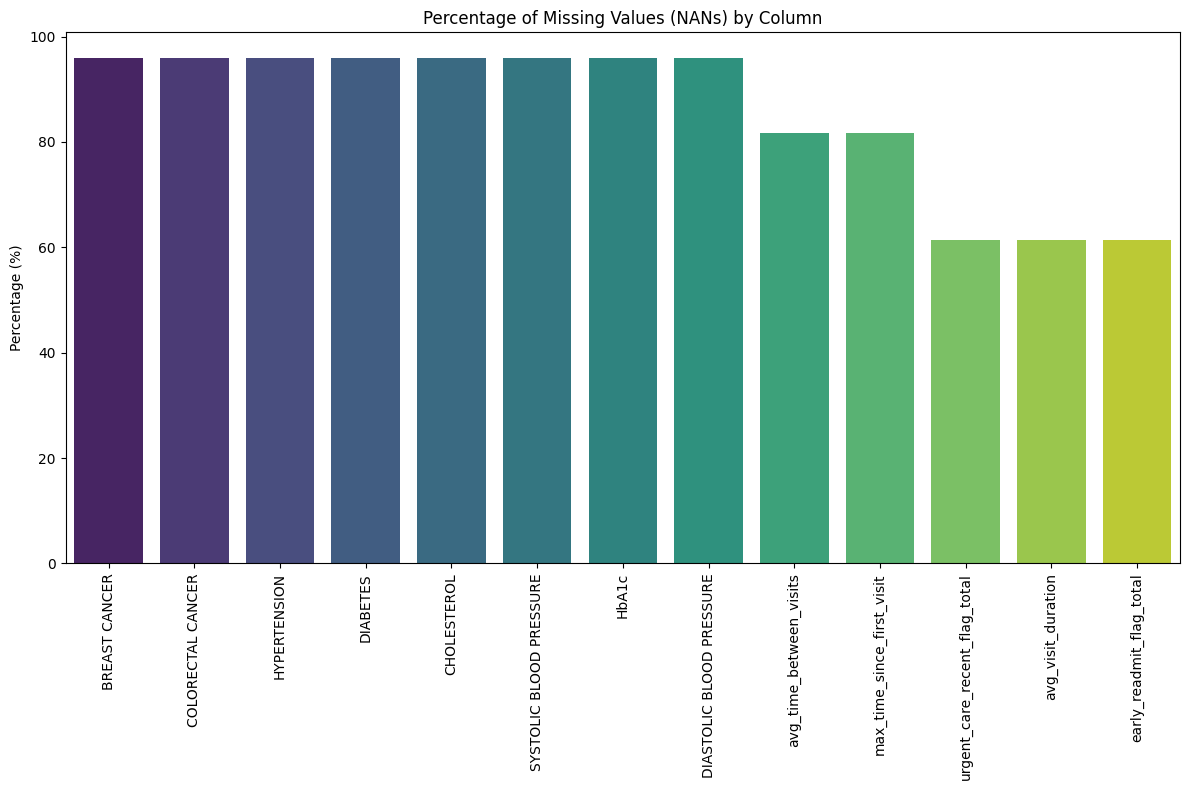

In [21]:

# NAN Analysis
nan_counts = merged_df.isnull().sum()
nan_percentage = (merged_df.isnull().sum() / len(merged_df)) * 100

nan_df = pd.DataFrame({
    'NAN Count': nan_counts,
    'NAN Percentage': nan_percentage
}).sort_values(by='NAN Percentage', ascending=False)

print("Missing Value Analysis:")
print(nan_df)

nan_df_filtered = nan_df[nan_df['NAN Percentage'] > 0]

# Plotting Missing Values
plt.figure(figsize=(12, 8))
sns.barplot(x=nan_df_filtered.index, y=nan_df_filtered['NAN Percentage'], palette='viridis')
plt.xticks(rotation=90)
plt.title('Percentage of Missing Values (NANs) by Column')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


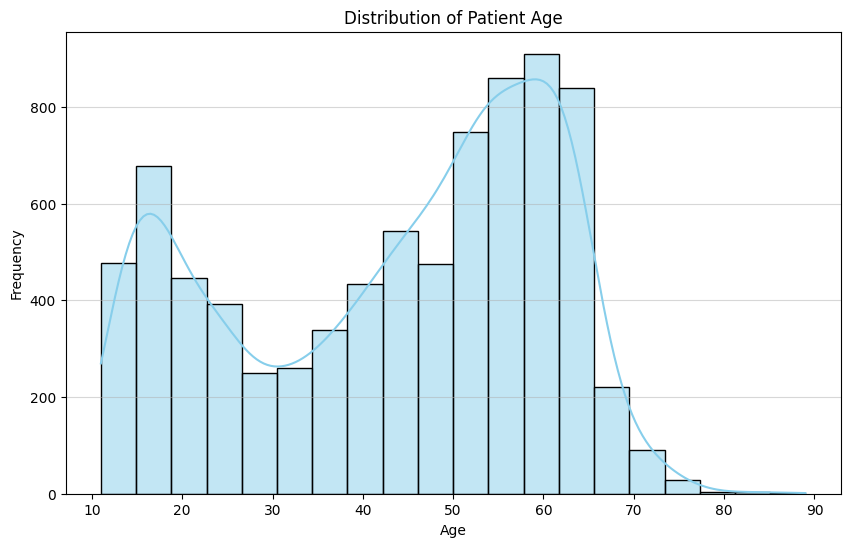

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['age'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

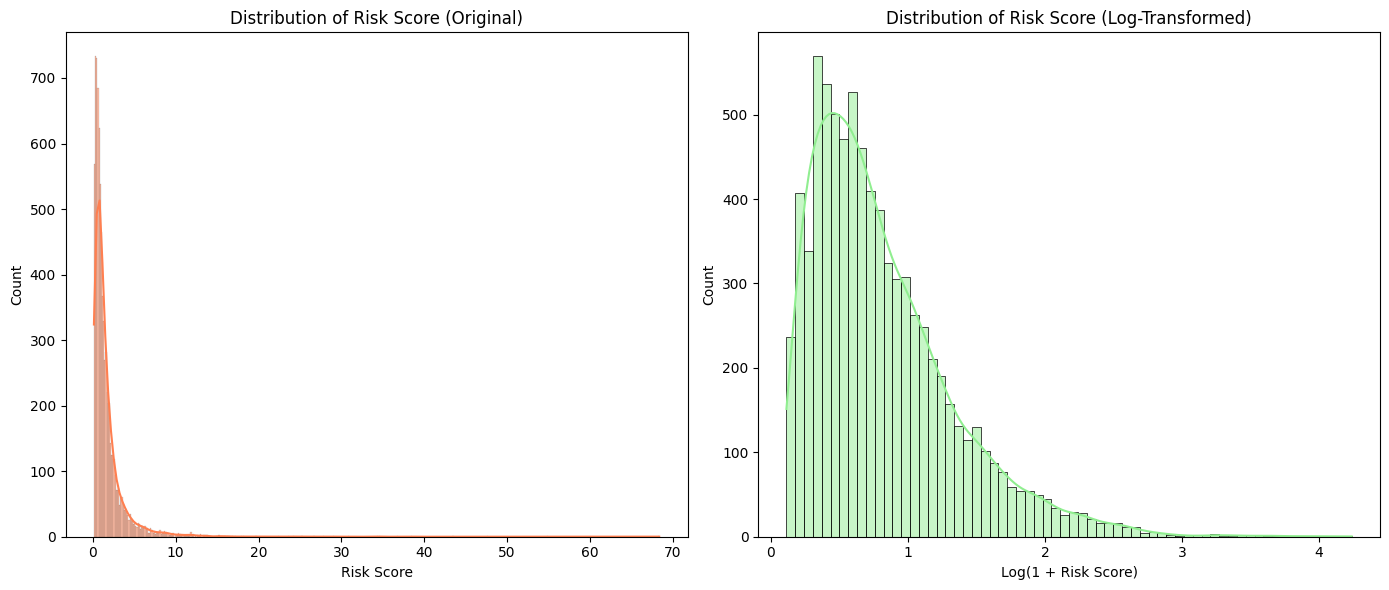

In [23]:
# Risk Score Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original Distribution
sns.histplot(merged_df['risk_score'].dropna(), ax=axes[0], color='coral', kde=True)
axes[0].set_title('Distribution of Risk Score (Original)')
axes[0].set_xlabel('Risk Score')

# Log-Transformed Distribution
sns.histplot(np.log1p(merged_df['risk_score'].dropna()), ax=axes[1], color='lightgreen', kde=True)
axes[1].set_title('Distribution of Risk Score (Log-Transformed)')
axes[1].set_xlabel('Log(1 + Risk Score)')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


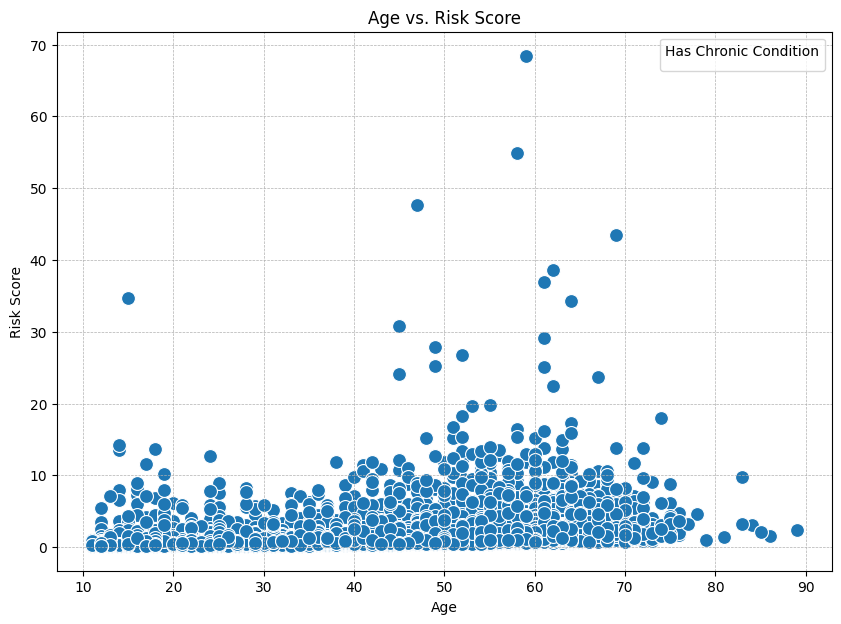

In [24]:
# Age vs risk_score

plt.figure(figsize=(10, 7))
sns.scatterplot(x='age',y='risk_score',data=merged_df,s=100)
plt.title('Age vs. Risk Score')
plt.xlabel('Age')
plt.ylabel('Risk Score')
plt.legend(title='Has Chronic Condition')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [25]:
# --- Assume df is your cleaned dataframe ---
# Set target variable (replace with your actual target column)
df = final_df.copy()
target_col = 'risk_score'   # example
X = df.drop(columns=[target_col,'patient_id','condition_description','hot_spotter_identified_at' ])
y = df[target_col]

# Train/val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# RandomForestRegressor model
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Get feature importance scores
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances.head(50))


/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

                          feature  importance
39              COLORECTAL CANCER    0.244021
43             avg_visit_duration    0.110280
0                             age    0.095399
51             chronic_complexity    0.060775
27                     diag_Other    0.050618
47     max_time_since_first_visit    0.035424
4              total_readmissions    0.033011
42        avg_time_between_visits    0.029635
12                       er_ratio    0.024028
45       hot_spotter_chronic_flag    0.021497
30     diag_Respiratory Infection    0.020063
6                   care_gap_days    0.019333
44       early_readmit_flag_total    0.017373
22              diag_Injury/Wound    0.015447
5                     visit_count    0.015061
28           diag_Other Infection    0.014827
8                 diagnosis_count    0.014676
41              condition_encoded    0.012721
13                inpatient_ratio    0.011554
11                     has_CANCER    0.011208
24           diag_Musculoskeletal 

In [ ]:
# --- XGBoost model ---

X = final_df.copy()
y = X['risk_score']

threshold = 0.001  # drop features with importance < 0.1%
important_features = feature_importances[feature_importances['importance'] > threshold]['feature']
X_selected = X[important_features]
# X_selected = X
# --- 1. Split the data ---
to_drop_x = ['hot_spotter_identified_at','risk_score','patient_id','condition_description']
for col in to_drop_x:
    if col in X_selected.columns:
        X_selected = X_selected.drop(columns=[col])

print(X_selected.columns)
        
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# --- 1. Scale the features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# --- 2. Implement an improved stacking model ---
estimators = [
    ('rf', RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42, n_jobs=-1)),
    ('xgb', XGBRegressor(n_estimators=150, learning_rate=0.1, random_state=42, n_jobs=-1)),
    ('lgb', lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05)),
    ('ridge', RidgeCV(alphas=np.logspace(-6, 6, 13)))
]
# --- THIS IS THE MODIFIED SECTION ---
# We have replaced the final_estimator from LassoCV to RidgeCV.
# RidgeCV uses L2 regularization, which may help create a more stable final model
# by shrinking coefficients instead of eliminating them entirely.
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(alphas=np.logspace(-6, 6, 13)), # <--- CHANGED FROM LassoCV
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

# --- 3. Train the model ---
print("Training the stacking regressor with RidgeCV as the final estimator...")
stacking_regressor.fit(X_train_scaled, y_train)
print("Training complete.")


# --- 4. Evaluate the model ---
# Training set metrics
print("\n--- Regression Metrics for Training Set ---")
y_train_pred = stacking_regressor.predict(X_train_scaled)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"R-squared (R²): {train_r2:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}\n")

# Testing set metrics
print("--- Regression Metrics for Testing Set ---")
y_test_pred = stacking_regressor.predict(X_test_scaled)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"R-squared (R²): {test_r2:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}\n")


# --- 5. Inspect the meta-learner's coefficients ---
print("Meta-learner (RidgeCV) coefficients:")
for i, est in enumerate(estimators):
    print(f"{est[0]}: {stacking_regressor.final_estimator_.coef_[i]:.4f}")

Index(['COLORECTAL CANCER', 'avg_visit_duration', 'age', 'chronic_complexity',
       'diag_Other', 'max_time_since_first_visit', 'total_readmissions',
       'avg_time_between_visits', 'er_ratio', 'hot_spotter_chronic_flag',
       'diag_Respiratory Infection', 'care_gap_days',
       'early_readmit_flag_total', 'diag_Injury/Wound', 'visit_count',
       'diag_Other Infection', 'diagnosis_count', 'condition_encoded',
       'inpatient_ratio', 'has_CANCER', 'diag_Musculoskeletal',
       'diag_Lower Respiratory', 'diag_GI', 'diag_ENT',
       'diag_Skin/Soft Tissue', 'diag_Pain', 'chronic_condition_count',
       'diag_Endocrine/Metabolic', 'urgent_ratio', 'has_DIABETES',
       'visit_type_INPATIENT', 'diag_Eye', 'visit_type_URGENT CARE',
       'visit_type_ER', 'urgent_care_recent_flag_total', 'BREAST CANCER',
       'chronic_flag', 'care_gap_ind', 'diag_Cardiovascular',
       'diag_Neurology/Psych', 'diag_Obstetric/Gyne', 'has_HYPERTENSION',
       'diag_Upper Respiratory'],
      

/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 43
[LightGBM] [Info] Start training from score 1.687411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 43
[LightGBM] [Info] Start training from score 1.695912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

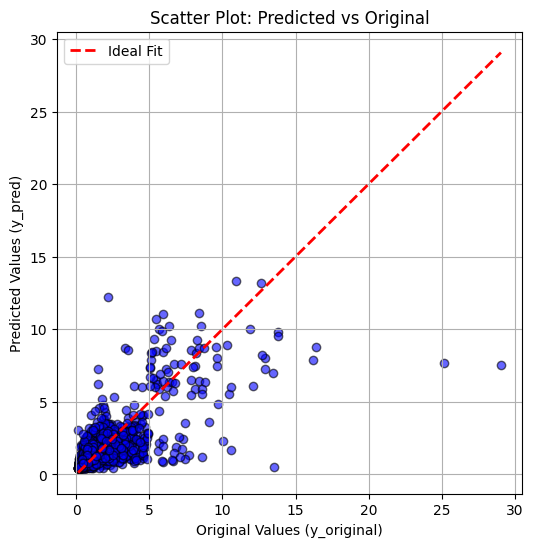

In [27]:

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('Original Values (y_original)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Scatter Plot: Predicted vs Original')
plt.legend()
plt.grid(True)
plt.show()
